In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [34]:
titanic_url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(titanic_url)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
df = df.drop(['PassengerId'], axis=1)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [37]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [38]:
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

In [39]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [40]:
from sklearn.model_selection import train_test_split

X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
X_train = preprocess_pipeline.fit_transform(X_train)
X_test = preprocess_pipeline.transform(X_test)

In [ ]:
logreg = LogisticRegression(max_iter=100000)
dt = DecisionTreeClassifier()
nb = GaussianNB()

models = [
    logreg,
    dt,
    nb
]
from sklearn.model_selection import cross_val_score
for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{model.__class__.__name__} CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
    model.fit(X_train, y_train)


from IPython.display import clear_output
clear_output()

preds = [model.predict(X_test) for model in models]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm

accs = [accuracy_score(y_test, pred) for pred in preds]
precs = [precision_score(y_test, pred) for pred in preds]
recs = [recall_score(y_test, pred) for pred in preds]
f1s = [f1_score(y_test, pred) for pred in preds]


In [43]:
metrics_df = pd.DataFrame({
    'Model': ['LogisticRegression', 'DecisionTree', 'GaussianNB'],
    'Accuracy': accs,
    'Precision': precs,
    'Recall': recs,
    'F1 Score': f1s
})

metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.798883,0.779412,0.716216,0.746479
1,DecisionTree,0.787709,0.730769,0.770270,0.750000
2,GaussianNB,0.770950,0.703704,0.770270,0.735484


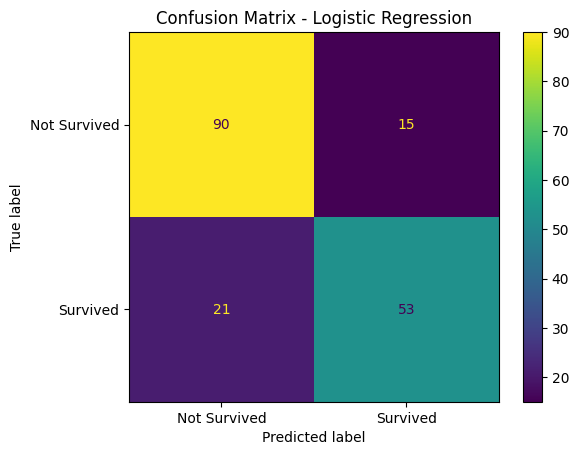

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, preds[0], display_labels=["Not Survived", "Survived"])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

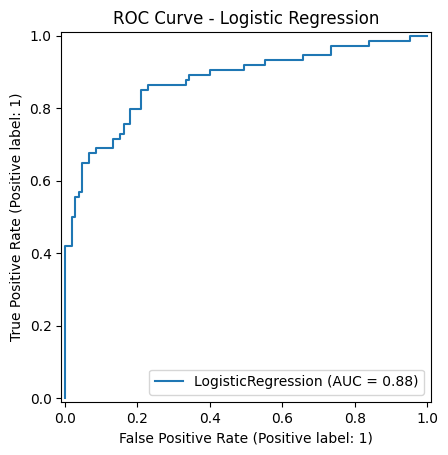

In [48]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

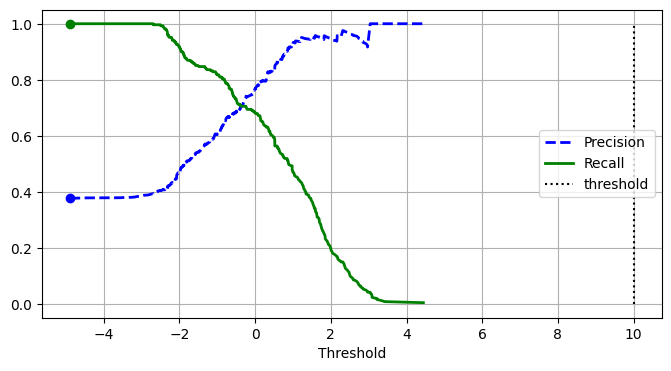

In [55]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(models[0], X_train, y_train, cv=3,
                             method="decision_function")

threshold = 10
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
#plt.axis([-50, 50, 0, 1.2])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
#save_fig("precision_recall_vs_threshold_plot")

plt.show()